<a href="https://colab.research.google.com/github/BondaiKa/Car-Model-Classification/blob/master/MainWorker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from datetime import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os 
import tensorflow_addons as tfa
import tensorflow_addons as tfma

%matplotlib inline
%load_ext tensorboard

In [2]:
print(tf.config.list_physical_devices("GPU"))
print(tf.config.list_logical_devices("CPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU')]


In [21]:
DATASET_DIR = "./GRZ_and_model_recognition/learn"
NUM_CLASSES = 11
BATCH_SIZE = 32

In [22]:

data_dir = os.listdir(DATASET_DIR+'/train')
data_dir

['KAMAZ_ALLKAMAZ_C',
 'LADA_PRIORA_B',
 'MAZDA_3_B',
 'RЕNАULТ_DUSТЕR_B',
 'SCANIA_ALLSCANIA_C',
 'TOYOTA_RАV4_B',
 'VOLVO_ALLVOLVO_C',
 'VОLКSWАGЕN_TIGUAN_B',
 'VОLКSWАGЕN_РОLО_B',
 'КIА_RIО_B',
 'НУUNDАI_SОLАRIS_B']

In [23]:
TRAIN_PATH = DATASET_DIR + '/train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  TRAIN_PATH,
  batch_size = BATCH_SIZE
)

Found 140727 files belonging to 11 classes.


In [24]:
class_names = train_ds.class_names
class_names

['KAMAZ_ALLKAMAZ_C',
 'LADA_PRIORA_B',
 'MAZDA_3_B',
 'RЕNАULТ_DUSТЕR_B',
 'SCANIA_ALLSCANIA_C',
 'TOYOTA_RАV4_B',
 'VOLVO_ALLVOLVO_C',
 'VОLКSWАGЕN_TIGUAN_B',
 'VОLКSWАGЕN_РОLО_B',
 'КIА_RIО_B',
 'НУUNDАI_SОLАRIS_B']

In [25]:
VAL_PATH = DATASET_DIR + '/val'
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  VAL_PATH,
  batch_size = BATCH_SIZE
)

Found 15643 files belonging to 11 classes.


(256, 256, 3)


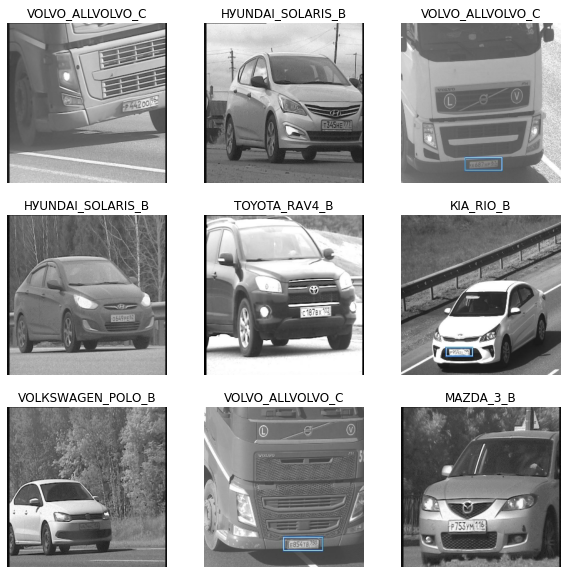

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    print(images[0].shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(256, 256, 256, 3)
(256,)


In [12]:
logdir = "logs/alex-model-1"
checkpoint_path = "models/alexnet/training__{epoch:02d}__{loss:.6f}/cp.ckpt"


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=7,monitor='val_loss')
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=0
)

In [13]:
alex_model = tf.keras.models.Sequential([
    # 1st conv
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)),
  tf.keras.layers.Conv2D(96, (11,11),strides=(4,4), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2,2)),
    # 2nd conv
  tf.keras.layers.Conv2D(256, (11,11),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
     # 3rd conv
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
    # 4th conv
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
    # 5th Conv
  tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2, 2)),
    # To Flatten layer
  tf.keras.layers.Flatten(),
    # To FC layer 1
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5),
    #To FC layer 2
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [14]:
alex_model.load_weights('./models/alexnet/training__03__2.265869/cp.ckpt')

In [15]:
alex_model.compile(
    optimizer=tf.optimizers.SGD(),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
alex_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 62, 96)        34944     
_________________________________________________________________
batch_normalization_5 (Batch (None, 62, 62, 96)        384       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 31, 31, 256)       2973952   
_________________________________________________________________
batch_normalization_6 (Batch (None, 31, 31, 256)       1024      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 31, 31, 384)      

In [ ]:
with tf.device('/device:GPU:0'):
    alex_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=100,
        callbacks=[
            tensorboard_callback, 
            cp_callback, 
            early_stop_callback, 
            reduce_lr_callback
        ],
)

Epoch 1/100
  1/550 [..............................] - ETA: 0s - loss: 2.3978 - accuracy: 0.1211WARNING:tensorflow:From C:\Users\User\.conda\envs\tf\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
550/550 [==============================] - ETA: 0s - loss: 2.3621 - accuracy: 0.1608
Epoch 00001: saving model to models/training__01__2.362088\cp.ckpt
550/550 [==============================] - 3249s 6s/step - loss: 2.3621 - accuracy: 0.1608 - val_loss: 2.3178 - val_accuracy: 0.2174
Epoch 2/100
550/550 [==============================] - ETA: 0s - loss: 2.3083 - accuracy: 0.2223
Epoch 00002: saving model to models/training__02__2.308257\cp.ckpt
550/550 [==============================] - 3029s 6s/step - loss: 2.3083 - accuracy: 0.2223 - val_loss: 2.2513 - val_accuracy: 0.2882
Epoch 3/100
550/550 [===============

In [18]:
with tf.device('/device:GPU:0'):
    alex_model.fit(
        train_ds,
        validation_data=val_ds,
        initial_epoch=3,
        epochs=100,
        callbacks=[
            tensorboard_callback, 
            cp_callback, 
            early_stop_callback, 
            reduce_lr_callback
        ],
)

Epoch 4/100
  1/550 [..............................] - ETA: 0s - loss: 2.2514 - accuracy: 0.2969WARNING:tensorflow:From C:\Users\User\.conda\envs\tf\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
550/550 [==============================] - ETA: 0s - loss: 2.2317 - accuracy: 0.3053
Epoch 00004: saving model to models/alexnet/training__04__2.231710\cp.ckpt
550/550 [==============================] - 3940s 7s/step - loss: 2.2317 - accuracy: 0.3053 - val_loss: 2.1820 - val_accuracy: 0.3556
Epoch 5/100
 79/550 [===>..........................] - ETA: 41:09 - loss: 2.2162 - accuracy: 0.3209

KeyboardInterrupt: 

In [24]:
%tensorboard --logdir logs/alex-model-1/ 

Reusing TensorBoard on port 6006 (pid 8460), started 0:01:01 ago. (Use '!kill 8460' to kill it.)

In [26]:
logdir = "logs/vgg-model-1" 
checkpoint_path = "models/vgg/training__{epoch:02d}__{val_accuracy:.6f}/cp.ckpt"


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=6,monitor='val_loss')
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=4, verbose=1, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=0
)

In [27]:
vgg_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(input_shape=(256, 256, 3), filters=64, kernel_size=3, padding="same", activation="relu"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding="same", activation="relu"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(pool_size=2,strides=2),

  tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

  tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

  tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
  tf.keras.layers.ZeroPadding2D(padding=1),
  tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(units=256, activation="relu"),
  tf.keras.layers.Dense(units=256, activation="relu"),
  tf.keras.layers.Dense(units=NUM_CLASSES, activation="softmax")
])

In [28]:
vgg_model.compile(
    optimizer=tf.optimizers.SGD(),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
vgg_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization_22 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 256, 256, 32)      18464     
_________________________________________________________________
batch_normalization_23 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
batch_normalization_24 (Batc (None, 128, 128, 64)     

In [ ]:
with tf.device('/device:GPU:0'):
    vgg_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=100,
        callbacks=[
            tensorboard_callback, 
            cp_callback, 
            early_stop_callback,
            reduce_lr_callback
        ],
)

Epoch 1/100
   1/4398 [..............................] - ETA: 0s - loss: 2.3995 - accuracy: 0.0938WARNING:tensorflow:From C:\Users\User\.conda\envs\tf\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
4398/4398 [==============================] - ETA: 0s - loss: 2.0121 - accuracy: 0.5356
Epoch 00001: saving model to models/vgg/training__01__0.620469\cp.ckpt
4398/4398 [==============================] - 5097s 1s/step - loss: 2.0121 - accuracy: 0.5356 - val_loss: 1.9244 - val_accuracy: 0.6205
Epoch 2/100
4398/4398 [==============================] - ETA: 0s - loss: 1.7525 - accuracy: 0.7973 
Epoch 00002: saving model to models/vgg/training__02__0.762769\cp.ckpt
4398/4398 [==============================] - 76514s 17s/step - loss: 1.7525 - accuracy: 0.7973 - val_loss: 1.7836 - val_accuracy: 0.7628
Epoch 3/100
439